In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import datetime
!pip install xgboost
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

# Loading the Data

In [ ]:
train_df=pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test_df=pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

In [ ]:
train_df

# Preprocessing

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
train_df.isnull().sum()/len(train_df)*100

#### find the percentage of missing values in each column

In [ ]:
train_df.nunique()

In [ ]:
one_unique_value = train_df.columns[train_df.nunique()==1]
print(one_unique_value)

#### check for columns with nunique() values equal to 1

In [ ]:
train_df = train_df.drop(columns= ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled'], errors='ignore')

#### drop those columns with nunique() values equal to 1

In [ ]:
train_df['target'].value_counts()/len(train_df)*100


#### the dataset looks balanced

In [ ]:
train_df['PrimaryDiskType'] = train_df['PrimaryDiskType'].replace(['UNKNOWN','Unknown','Unspecified'], 'UNKNOWN')
train_df['PrimaryDiskType'] = train_df['PrimaryDiskType'].fillna('UNKNOWN')

#### Standardizing the 'PrimaryDiskType' column by replacing variations of 'UNKNOWN' and filling missing values with 'UNKNOWN'


In [ ]:
columns_to_drop = [col for col in train_df.columns if train_df[col].nunique() > 10000]

# Drop the identified columns
train_df = train_df.drop(columns=columns_to_drop, errors='ignore')
#columns_to_drop

#### Identifying columns with more than 10,000 unique values and dropping them to reduce dimensionality


In [ ]:
columns_to_drop

#### these columns with more than 10,000 unique values were dropped off

In [ ]:
num_cols = train_df.select_dtypes(include=['int']).columns.tolist()
obj_cols = train_df.select_dtypes(include=['object']).columns.tolist()
float_cols = train_df.select_dtypes(include=['float64']).columns.tolist()

print("\nNumeric columns:", len(num_cols), num_cols)
print("\nObject columns:", len(obj_cols), obj_cols)
print("\nFloat columns:", len(float_cols), float_cols)

#### Categorizing columns based on data type: integers, objects (categorical/text), and floats


In [ ]:
def impute_missing_by_strategy(df, num_cols, obj_cols, float_cols, strategy='most_frequent'):
    
    imputer_num = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer_obj = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # Use 'most_frequent' for object columns
    imputer_float = SimpleImputer(missing_values=np.nan, strategy=strategy)

    # Impute numerical columns
    if num_cols:
        df[num_cols] = imputer_num.fit_transform(df[num_cols])
    # Impute object columns
    if obj_cols:
        df[obj_cols] = imputer_obj.fit_transform(df[obj_cols])
    # Impute float columns
    if float_cols:
        df[float_cols] = imputer_float.fit_transform(df[float_cols])

    return df

train_df = impute_missing_by_strategy(train_df, num_cols, obj_cols, float_cols, strategy='most_frequent')

#### Function to impute missing values in a DataFrame based on column data types.
#### (1) Numerical and float columns are imputed using the specified strategy (default: 'most_frequent').
#### (2) Object (categorical) columns are always imputed using the 'most_frequent' strategy.
#### (3) The function applies SimpleImputer to replace NaN values accordingly.
#### Finally, the function is called to impute missing values in `train_df` using 'most_frequent' strategy.


In [ ]:
train_df.info()

In [ ]:
train_df.describe()

#### Finally all the null values have been handled carefully along with deletion certain columns as mentioned above 

In [ ]:
# Convert int64 columns to float64
for col in num_cols:
    train_df[col] = train_df[col].astype('float64')

print(train_df.info())


In [ ]:
float_cols1 = train_df.select_dtypes(include=['float64']).columns.tolist()

In [ ]:
len(float_cols1)

#### Convert int64 columns to float64

In [ ]:
cat_col = ['Processor', 'OSArchitecture', 'EngineVersion', 'SignatureVersion', 'DateAS', 'PowerPlatformRole', 'DateOS', 'NumericOSVersion']

TOP_N = 10  

# Binning function
def bin_categorical(column, df, top_n=TOP_N):
    top_categories = df[column].value_counts().nlargest(top_n).index
    df[column + "_Binned"] = df[column].apply(lambda x: x if x in top_categories else "Other")

# Apply binning to top 5 object features
for i in cat_col:
    bin_categorical(i, train_df)

    plt.figure(figsize=(12, 6))
    ax = sns.countplot(x=f"{i}_Binned", hue="target", data=train_df, palette="coolwarm")
    
    plt.title(f"{i} (Binned) Distribution by Target")
    plt.xticks(rotation=45)
    plt.xlabel(i)
    plt.ylabel("Count")
    plt.show()

In [ ]:
correlations = {}
for col in float_cols:
    if col != 'target':
        correlation = train_df[col].corr(train_df['target'])
        correlations[col] = abs(correlation)

sorted_correlations = dict(sorted(correlations.items(), key=lambda item: item[1], reverse=True))

for col, correlation in sorted_correlations.items():
    print(f"{col}: {correlation}")


In [ ]:
correlations_obj = {}
for col in obj_cols:
    if col != 'target':
        # Use Label Encoding to convert object columns to numerical representations for correlation calculation
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col])
        correlation = train_df[col].corr(train_df['target'])
        correlations_obj[col] = abs(correlation)

# Sort correlations in descending order
sorted_correlations_obj = dict(sorted(correlations_obj.items(), key=lambda item: item[1], reverse=True))

# Print the sorted correlations
for col, correlation in sorted_correlations_obj.items():
    print(f"{col}: {correlation}")

In [ ]:
import pandas as pd

# Select top 7 numerical features
top_7_numerical = list(sorted_correlations.keys())

# Select top 5 object features
top_5_object = list(sorted_correlations_obj.keys())[:5]

print("Top numerical features:", top_7_numerical)
print("Top 5 object features:", top_5_object)

#Combine top features
top_features = top_7_numerical + top_5_object
print("\nCombined top features:", top_features)


In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(train_df[top_features + ['target']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x=train_df['target'], palette='coolwarm')

# Display count on bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 5, int(p.get_height()), 
            ha='center', fontsize=12, fontweight='bold')

plt.title("Target Variable Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
train_df['target'].value_counts().plot.pie(autopct='%1.1f%%', colors=['red', 'blue'], startangle=90, shadow=True)
plt.title("Percentage Distribution of Target Variable")
plt.ylabel('')
plt.show()

In [ ]:
for i in top_7_numerical:
    train_df[i].hist(figsize=(12, 8), bins=30, color='steelblue', edgecolor='black')
    plt.suptitle(f"Distribution of {i}", fontsize=15)
    plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df[top_7_numerical + ['target']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Top Numerical Features with Target")
plt.show()

In [ ]:
for i in top_7_numerical:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=train_df[i], orient="h")
    plt.title(f"Boxplot for {i}")
    plt.xlabel(col)
    plt.show()

In [ ]:
sns.pairplot(train_df, vars=top_features[:6], hue="target", palette="coolwarm")
plt.show()

In [ ]:
skewness = train_df[top_features].skew()
print(skewness)
plt.figure(figsize=(10, 5))
sns.histplot(skewness, kde=True, color="blue")
plt.title("Skewness of Features")
plt.xlabel("Skewness")
plt.ylabel("Frequency")
plt.show()

In [ ]:
import math

num_features = len(top_features)
rows = math.ceil(num_features / 5)  # Adjust number of rows based on features

plt.figure(figsize=(15, rows * 3))  # Adjust figure height dynamically

for i, col in enumerate(top_features):
    plt.subplot(rows, 5, i + 1)  # Adjust subplot grid
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()

In [ ]:
train_df[top_features[:13]].hist(figsize=(14, 10), bins=30, color='steelblue', edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=15)
plt.show()

In [ ]:
sns.pairplot(train_df[top_7_numerical[:7] + ['target']])
plt.show()

In [ ]:
selected_columns = ['NumAntivirusProductsInstalled', 'AntivirusConfigID', 'TotalPhysicalRAMMB', 'IsAlwaysOnAlwaysConnectedCapable', 'IsSystemProtected', 'IsGamer', 'ProcessorCoreCount', 'PrimaryDiskCapacityMB', 'RealTimeProtectionState', 'NumAntivirusProductsEnabled', 'IsVirtualDevice', 'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal', 'IEVersionID', 'ProcessorModelID', 'FirmwareManufacturerID', 'RegionIdentifier', 'InternalBatteryNumberOfCharges', 'SMode', 'OEMNameID', 'PrimaryDisplayResolutionVertical', 'FirewallEnabled', 'OSInstallLanguageID', 'ProcessorManufacturerID', 'GeoRegionID', 'EnableLUA', 'Processor', 'OSArchitecture', 'EngineVersion', 'SignatureVersion', 'DateAS', 'target']
train_df= train_df[selected_columns]

# Verify the resulting DataFrame
print("Columns remaining in the DataFrame:", train_df.columns.tolist())
print(len(train_df.columns))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Ensure plots are displayed properly
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load your dataset (replace 'train_df' with your actual DataFrame)
# train_df = pd.read_csv("your_file.csv")  # Uncomment if loading from CSV

# Define numerical and categorical features (label encoding already applied)
top_numerical = [
    'NumAntivirusProductsInstalled', 'AntivirusConfigID', 'TotalPhysicalRAMMB', 
    'IsAlwaysOnAlwaysConnectedCapable', 'IsSystemProtected', 'IsGamer', 'ProcessorCoreCount', 
    'PrimaryDiskCapacityMB', 'RealTimeProtectionState', 'NumAntivirusProductsEnabled', 
    'IsVirtualDevice', 'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal'
]

top_categorical = [
    'Processor', 'OSArchitecture', 'EngineVersion', 'SignatureVersion', 
    'DateAS', 'PowerPlatformRole', 'DateOS', 'NumericOSVersion'
]

top_features = top_numerical + top_categorical

# ----------------- Target Variable Distribution -----------------
plt.figure(figsize=(6,4))
ax = sns.countplot(x=train_df['target'], palette='coolwarm')
plt.title("Target Variable Distribution")
plt.xlabel("Target")
plt.ylabel("Count")

# Annotate the bars with counts
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width()/2, p.get_height()), ha='center', va='bottom')

plt.show()

# ----------------- Correlation Heatmap -----------------
plt.figure(figsize=(12,8))
sns.heatmap(train_df[top_numerical + ['target']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# ----------------- Distribution of Numerical Features -----------------
num_features = len(top_numerical)
rows = math.ceil(num_features / 4)  # Arrange in a 4-column layout

plt.figure(figsize=(15, rows * 3))
for i, col in enumerate(top_numerical):
    plt.subplot(rows, 4, i + 1)
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# ----------------- Skewness of Numerical Features -----------------
skewness = train_df[top_numerical].skew()
plt.figure(figsize=(10, 5))
sns.histplot(skewness, kde=True, color="blue")
plt.title("Skewness of Numerical Features")
plt.xlabel("Skewness")
plt.ylabel("Frequency")
plt.show()

# ----------------- Boxplots to Detect Outliers -----------------
plt.figure(figsize=(15, rows * 3))
for i, col in enumerate(top_numerical):
    plt.subplot(rows, 4, i + 1)
    sns.boxplot(y=train_df[col], color='steelblue')
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

# ----------------- Pairplot for Feature Relationships -----------------
sns.pairplot(train_df, vars=top_numerical[:6], hue="target", palette="coolwarm")
plt.show()

# ----------------- Countplots for Categorical Features (Using Binning) -----------------
for i in top_categorical[:5]:  # Limiting to first 5 for readability
    train_df[i] = pd.qcut(train_df[i].rank(method='first'), q=10, labels=False)  # Binning

    plt.figure(figsize=(12,6))
    ax = sns.countplot(x=i, hue='target', data=train_df, palette='coolwarm')
    plt.title(f"{i} Distribution by Target (Binned)")
    plt.xticks(rotation=45)
    plt.xlabel(i)
    plt.ylabel("Count")
    plt.show()

# ----------------- Feature Importance (Correlation with Target) -----------------
corr_with_target = train_df[top_numerical].corrwith(train_df["target"]).abs().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values, palette="coolwarm")
plt.title("Feature Importance Based on Correlation with Target")
plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("Correlation with Target")
plt.show()

# ----------------- KDE Plots to Compare Feature Distribution Across Target Classes -----------------
for col in top_numerical[:5]:  # Limiting to first 5 for readability
    plt.figure(figsize=(10,5))
    sns.kdeplot(data=train_df, x=col, hue="target", fill=True, palette="coolwarm")
    plt.title(f"{col} Distribution by Target")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()


In [ ]:
y= train_df.target.copy()
x= train_df.drop('target', axis=1).copy()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
X_train,X_val,y_train,y_val = train_test_split(x, y, test_size=0.25, random_state=3)

# Pipeline

In [ ]:
from sklearn.compose import make_column_selector as mcs
num_sel = mcs(dtype_exclude='object')
cat_sel = mcs(dtype_include='object')

In [ ]:
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
#X_test_num_selected = selector.transform(X_test_num)

X_test_selected = selector.transform(X_val)
X_train_selected

In [ ]:
selected_features = X_train.columns[selector.get_support()]
print(selected_features)

In [ ]:
pca = PCA(n_components=0.95)
X_train_transformed = pca.fit_transform(X_train_selected)
X_test_transformed = pca.transform(X_test_selected)
X_train_transformed

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer for LabelEncoder
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def _init_(self):
        self.encoders = {}

    def fit(self, X, y=None):
        for column in X.columns:
            self.encoders[column] = LabelEncoder().fit(X[column])
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for column, encoder in self.encoders.items():
            X_encoded[column] = encoder.transform(X[column])
        return X_encoded

# Create numerical and categorical pipelines
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('label_encoder', MultiColumnLabelEncoder())
])

# Combine numerical and categorical pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('numerical', num_pipeline, num_sel(X_train)),
    ('categorical', cat_pipeline, cat_sel(X_train))
])

# Create the full pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor)
])

# Fit the pipeline
pipe.fit(X_train)

In [ ]:
X_train.shape

In [ ]:
X_train_trf = pipe.transform(X_train)
X_val_trf = pipe.transform(X_val)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nb_model = GaussianNB()
nb_model.fit(X_train_transformed, y_train)
y_pred_nb = nb_model.predict(X_test_transformed)

print("Naïve Bayes Accuracy:", accuracy_score(y_val, y_pred_nb))
print("Naïve Bayes Report:\n", classification_report(y_val, y_pred_nb))

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_transformed, y_train)
y_pred_knn = knn_model.predict(X_test_transformed)

print("KNN Accuracy:", accuracy_score(y_val, y_pred_knn))
print("KNN Report:\n", classification_report(y_val, y_pred_knn))

svm_model = SVC(kernel='rbf', C=1.0)
svm_model.fit(X_train_transformed, y_train)
y_pred_svm = svm_model.predict(X_test_transformed)

print("SVM Accuracy:", accuracy_score(y_val, y_pred_svm))
print("SVM Report:\n", classification_report(y_val, y_pred_svm))

models = ['Naïve Bayes', 'KNN', 'SVM']
accuracies = [
    accuracy_score(y_val, y_pred_nb),
    accuracy_score(y_val, y_pred_knn),
    accuracy_score(y_val, y_pred_svm)
]

# Print accuracy comparison
for model, acc in zip(models, accuracies):
    print(f"{model}: {acc:.4f}")

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize DummyClassifier with the 'most_frequent' strategy
dummy_clf = DummyClassifier(strategy="most_frequent")

# Train the classifier
dummy_clf.fit(X_train_trf, y_train)

# Make predictions on the validation set
y_pred = dummy_clf.predict(X_val_trf)

# Evaluate the classifier
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
class_report = classification_report(y_val, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000) # Increased max_iter

# Train the model
logreg_model.fit(X_train_trf, y_train)

# Make predictions
y_pred_logreg = logreg_model.predict(X_val_trf)

# Evaluate the model
accuracy_logreg = accuracy_score(y_val, y_pred_logreg)
conf_matrix_logreg = confusion_matrix(y_val, y_pred_logreg)
class_report_logreg = classification_report(y_val, y_pred_logreg)

print(f"Logistic Regression Accuracy: {accuracy_logreg}")
print(f"Logistic Regression Confusion Matrix:\n{conf_matrix_logreg}")
print(f"Logistic Regression Classification Report:\n{class_report_logreg}")


In [ ]:
from sklearn.linear_model import SGDClassifier

# Initialize SGDClassifier
sgd_clf = SGDClassifier(random_state=42)

# Train the classifier
sgd_clf.fit(X_train_trf, y_train)

# Make predictions
y_pred_sgd = sgd_clf.predict(X_val_trf)

# Evaluate the model
accuracy_sgd = accuracy_score(y_val, y_pred_sgd)
conf_matrix_sgd = confusion_matrix(y_val, y_pred_sgd)
class_report_sgd = classification_report(y_val, y_pred_sgd)

print(f"SGD Classifier Accuracy: {accuracy_sgd}")
print(f"SGD Classifier Confusion Matrix:\n{conf_matrix_sgd}")
print(f"SGD Classifier Classification Report:\n{class_report_sgd}")


In [ ]:
# Initialize XGBoost classifier
xgb_clf = XGBClassifier(random_state=42)

# Train the classifier
xgb_clf.fit(X_train_trf, y_train)

# Make predictions
y_pred_xgb = xgb_clf.predict(X_val_trf)

# Evaluate the model
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)
class_report_xgb = classification_report(y_val, y_pred_xgb)

print(f"XGBoost Classifier Accuracy: {accuracy_xgb}")
print(f"XGBoost Classifier Confusion Matrix:\n{conf_matrix_xgb}")
print(f"XGBoost Classifier Classification Report:\n{class_report_xgb}")


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.19),
    'max_depth': randint(3, 7),
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2)
}

xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_trf, y_train)

best_xgb_clf = random_search.best_estimator_
best_score = random_search.best_score_

print(f"Best XGBoost parameters: {random_search.best_params_}")
print(f"Best XGBoost cross-validation score: {best_score}")

y_pred = best_xgb_clf.predict(X_val_trf)
accuracy = accuracy_score(y_val, y_pred)
print(f"Best XGBoost accuracy on the validation set: {accuracy}")
print(classification_report(y_val, y_pred))


# Working on Test data

In [ ]:
test_df['PrimaryDiskType'] = test_df['PrimaryDiskType'].replace(['UNKNOWN','Unknown','Unspecified'], 'UNKNOWN')
test_df['PrimaryDiskType'] = test_df['PrimaryDiskType'].fillna('UNKNOWN')

In [ ]:
test_df = test_df.drop(columns= ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled', 'MachineID', 'CityID',
 'OEMModelID',
 'SystemVolumeCapacityMB',
 'FirmwareVersionID'], errors='ignore')

In [ ]:
num_cols = test_df.select_dtypes(include=['int']).columns.tolist()
obj_cols = test_df.select_dtypes(include=['object']).columns.tolist()
float_cols = test_df.select_dtypes(include=['float64']).columns.tolist()

print("\nNumeric columns:", len(num_cols), num_cols)
print("\nObject columns:", len(obj_cols), obj_cols)
print("\nFloat columns:", len(float_cols), float_cols)

In [ ]:
def impute_missing_by_strategy(df, num_cols, obj_cols, float_cols, strategy='most_frequent'):
    """Imputes missing values in specified columns using a specified strategy."""

    imputer_num = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer_obj = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # Use 'most_frequent' for object columns
    imputer_float = SimpleImputer(missing_values=np.nan, strategy=strategy)

    # Impute numerical columns
    if num_cols:
        df[num_cols] = imputer_num.fit_transform(df[num_cols])
    # Impute object columns
    if obj_cols:
        df[obj_cols] = imputer_obj.fit_transform(df[obj_cols])
    # Impute float columns
    if float_cols:
        df[float_cols] = imputer_float.fit_transform(df[float_cols])

    return df

# Example usage (replace with your desired strategy):
test_df = impute_missing_by_strategy(test_df, num_cols, obj_cols, float_cols, strategy='most_frequent')
# Other strategies : 'mean', 'most_frequent', 'constant'


In [ ]:
test_df.info()

In [ ]:
# Convert int64 columns to float64
for col in num_cols:
    test_df[col] = test_df[col].astype('float64')

print(test_df.info())

In [ ]:
selected_columns1 = ['NumAntivirusProductsInstalled', 'AntivirusConfigID', 'TotalPhysicalRAMMB', 'IsAlwaysOnAlwaysConnectedCapable', 'IsSystemProtected', 'IsGamer', 'ProcessorCoreCount', 'PrimaryDiskCapacityMB', 'RealTimeProtectionState', 'NumAntivirusProductsEnabled', 'IsVirtualDevice', 'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal', 'IEVersionID', 'ProcessorModelID', 'FirmwareManufacturerID', 'RegionIdentifier', 'InternalBatteryNumberOfCharges', 'SMode', 'OEMNameID', 'PrimaryDisplayResolutionVertical', 'FirewallEnabled', 'OSInstallLanguageID', 'ProcessorManufacturerID', 'GeoRegionID', 'EnableLUA', 'Processor', 'OSArchitecture', 'EngineVersion', 'SignatureVersion', 'DateAS']
test_df= test_df[selected_columns1]

# Verify the resulting DataFrame
print("Columns remaining in the DataFrame:", test_df.columns.tolist())
print(len(test_df.columns))

In [ ]:
import numpy as np
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score


# Step 1: Define Optuna objective function
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    }

    gb_model = GradientBoostingClassifier(**params, random_state=42)
    return cross_val_score(gb_model, X_train_trf, y_train, cv=3, scoring='accuracy').mean()

# Step 2: Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

# Get best parameters
best_params = study.best_params
print("Best parameters:", best_params)

# Step 3: Train final model with best parameters
best_model = GradientBoostingClassifier(**best_params, random_state=42)
best_model.fit(X_train_trf, y_train)

# Step 4: Evaluate on validation set
y_val_pred = best_model.predict(X_val_trf)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Tuned Gradient Boosting Classifier Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Step 5: Apply to test data
#y_test_pred = best_model.predict(test_df)

# Now y_test_pred contains the predictions for your test data

In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
import time

param_grid = {
    'max_depth': [5, 7, 9],  
    'learning_rate': [0.01, 0.04],  
    'n_estimators': [100, 150, 200],  
    'min_samples_split': [10, 15, 20],  
    'min_samples_leaf': [15, 20, 25], 
    'subsample': [0.8, 0.9] 
}

# Print the total number of combinations
total_combinations = np.prod([len(values) for values in param_grid.values()])
print(f"Total possible parameter combinations: {total_combinations}")

# Start timing
start_time = time.time()

# Use RandomizedSearchCV with fewer iterations and verbose output
gb_model = GradientBoostingClassifier(random_state=42)
random_search = RandomizedSearchCV(
    gb_model, 
    param_grid, 
    n_iter=8,  # Reduced number of iterations
    cv=3, 
    scoring='accuracy', 
    random_state=42,
    verbose=2,  # Add verbose output to see progress
    n_jobs=-1   # Use all available cores
)

print("Starting hyperparameter search...")
random_search.fit(X_train_trf, y_train)
best_params = random_search.best_params_

# Calculate and print elapsed time
elapsed_time = time.time() - start_time
print(f"Search completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
print("Best parameters:", best_params)

# Train final model with best parameters
best1_model = GradientBoostingClassifier(**best_params, random_state=42)
best1_model.fit(X_train_trf, y_train)

# Evaluate on validation set
y_val_pred = best1_model.predict(X_val_trf)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Tuned Gradient Boosting Classifier Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define best parameters
best_params_grid = {
    'max_depth': 7,
    'learning_rate': 0.03334792399100812,
    'n_estimators': 154,
    'min_samples_split': 13,
    'min_samples_leaf': 19,
    'subsample': 0.806481498073608,
}

# Train final model with best parameters
gb_best_model = GradientBoostingClassifier(**best_params_grid, random_state=42)
gb_best_model.fit(X_train_trf, y_train)

# Evaluate on validation set
y_val_pred = gb_best_model.predict(X_val_trf)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Tuned Gradient Boosting Classifier Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

'''# Apply to test data
y_test_pred = gb_best_model.predict(test_df)

# Now y_test_pred contains the predictions for your test data'''


In [ ]:
from sklearn.compose import make_column_selector as mcs
num_sel = mcs(dtype_exclude='object')
cat_sel = mcs(dtype_include='object')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}

    def fit(self, X, y=None):
        for column in X.columns:
            self.encoders[column] = LabelEncoder().fit(X[column])
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for column, encoder in self.encoders.items():
            X_encoded[column] = encoder.transform(X[column])
        return X_encoded

# Create numerical and categorical pipelines
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('label_encoder', MultiColumnLabelEncoder())
])

# Combine numerical and categorical pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('numerical', num_pipeline, num_sel(test_df)),
    ('categorical', cat_pipeline, cat_sel(test_df))
])

# Create the full pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor)
])

# Fit the pipeline
pipe.fit(test_df)


In [ ]:
test_df_trf = pipe.transform(test_df)
y_test_pred = best_model.predict(test_df_trf)

In [ ]:
prediction_df = pd.DataFrame({
    'id': test_df.index,   
    'target': y_test_pred       
})

In [ ]:
prediction_df.to_csv('submission.csv', index=False)


| Model                          | Accuracy  |
|--------------------------------|----------|
| Naïve Bayes                   | 0.5150   |
| KNN                            | 0.5327   |
| SVM                            | 0.5222   |
| DummyClassifier                | 0.5105   |
| Logistic Regression            | 0.5875   |
| SGD Classifier                 | 0.5800   |
| XGBoost Classifier             | 0.6113   |
| Tuned Gradient Boosting        | 0.6132   |

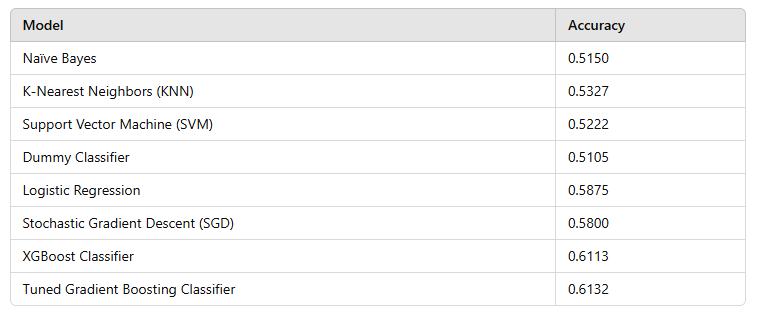
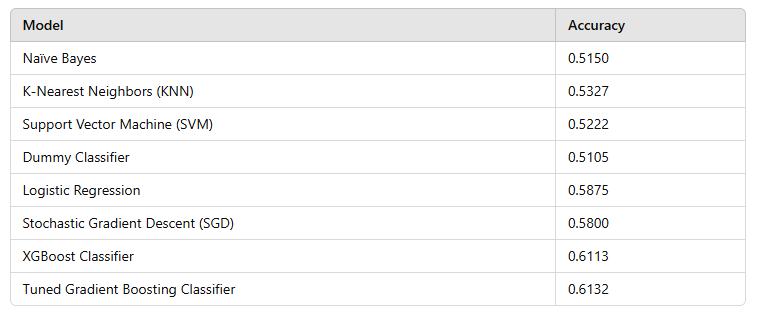
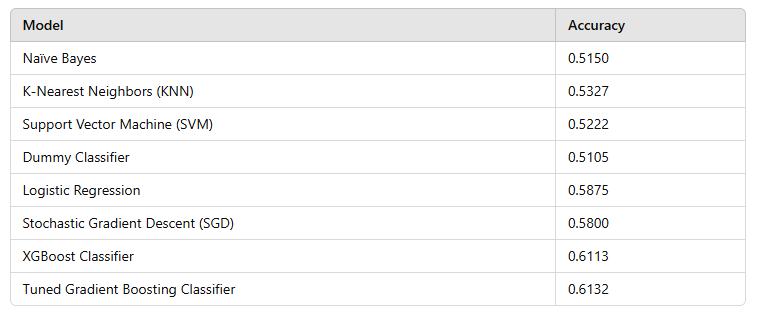
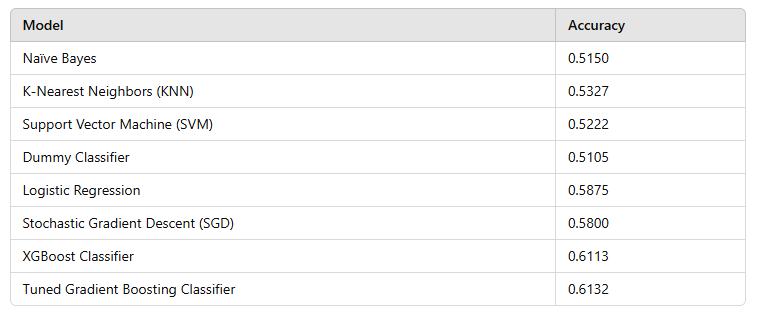